In [1]:
"""
Configs:
    # Env
    env_id="Gridworld03-v01", size=3x3, action_reward=[-14, 10], terminal_reward=5
     - once in the goal state, each action ends the episode and returns a reward of 5
     - no clear episodes, continuously train the agent with num_train_steps, 
       if the agent reaches terminal, just reset environment and keep training 
    # Params
    eps_sched_fn=poly(0.5), lr_sched_fn=poly(0.8)
    # Algos
    haver2, action_sigma=adaptive(1), haver_delta=0.01, haver_const=varied
Status:
"""

from collections import defaultdict
import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
sns.set_palette("tab20")
colors = sns.color_palette("bright")

import time
from tqdm import tqdm 
import multiprocessing

# import gymnasium as gym
import gym
import gym_examples
from gym.wrappers import FlattenObservation

from algos import *
from utils import *

In [2]:

random.seed(123)
np.random.seed(123)
tdqm_disable = True

# params
env_id = "gym_examples/GridWorld03-v1"
gridworld_size = 3
max_steps = 20
gamma = 0.95

num_trials = 500
num_steps_train = 10000
num_episodes_eval = 100

lr_sched_type = "poly"
lr_sched_fn = create_lr_sched_fn(lr_sched_type)

max_eps = 1.0
min_eps = 0.05
decay_rate = 0.0005
eps_sched_type = "poly"
eps_sched_fn = create_eps_sched_fn(eps_sched_type, min_eps, max_eps, decay_rate)

haver_const = 20.0
est_name = "haver" 
q_algo_name = "haver_q_learning"
q_algo = create_q_algo(q_algo_name)

# create gym env
env = gym.make(env_id, size=gridworld_size, action_reward=[-10.2,10], terminal_reward=5)
env_wrapped = FlattenObservation(env)
num_actions = env_wrapped.action_space.n
# print(f"num_actions = {num_actions}")
# print(env_wrapped.reset())
# stop

manager = multiprocessing.Manager()
episode_start_sigmahats_list = manager.list()
episode_rewards_list = manager.list()
episode_start_muhats_list = manager.list()

def run_trial(i_trial, args):

    random.seed(10000+i_trial)
    np.random.seed(10000+i_trial)

    # env = gym.make(env_id, size=gridworld_size)
    # env_wrapped = FlattenObservation(env)
    # env_wrapped.reset(seed=10000+i_trial)

    lr_sched_fn = create_lr_sched_fn(lr_sched_type)
    eps_sched_fn = create_eps_sched_fn(eps_sched_type, min_eps, max_eps, decay_rate)
    q_algo = create_q_algo(args["est_name"])

    Q_table, stats = q_algo(
        env_wrapped, num_actions, num_steps_train,
        gamma, lr_sched_fn, eps_sched_fn, tdqm_disable, args)

    episode_start_sigmahats, episode_rewards, episode_start_muhats= zip(*stats)
    episode_start_sigmahats_list.append(episode_start_sigmahats)
    episode_rewards_list.append(episode_rewards)
    episode_start_muhats_list.append(episode_start_muhats)



args = dict()
args["action_sigma"] = 1
args["haver_delta"] = 0.01
args["haver_const"] = 10.0
args["weightedms_num_data"] = 1000

pool = multiprocessing.Pool()

haver_const_ary = [1.0, 2.5, 5.0, 7.5, 10.0]
haver_name_ary = [f"haver_{x}" for x in haver_const_ary]

est_name_ary = ["weightedms", "double", "max"]
est_name_ary = est_name_ary + haver_name_ary

episode_start_sigmahats_mean_dict = defaultdict()
episode_rewards_mean_dict = defaultdict()
episode_start_muhats_mean_dict = defaultdict()

for est_name in est_name_ary:
    start_time = time.time()
    print(f"\n-> est_name = {est_name}")
    if "haver" in est_name:
        args["est_name"] = "haver2"
        args["haver_const"] = float(est_name.split("_")[-1])
    else:
        args["est_name"] = est_name
    
         
    pool.starmap(run_trial, [(i, args) for i in range(num_trials)])

    episode_start_sigmahats_ary = np.hstack([episode_start_sigmahats_list])
    episode_rewards_ary = np.hstack([episode_rewards_list])
    episode_start_muhats_ary = np.hstack([episode_start_muhats_list])

    episode_start_sigmahats_mean_dict[est_name] = np.mean(episode_start_sigmahats_ary, 0)
    episode_rewards_mean_dict[est_name] = np.mean(episode_rewards_ary, 0)
    episode_start_muhats_mean_dict[est_name] = np.mean(episode_start_muhats_ary, 0)
    print(f"last_episode_start_sigmahat = {episode_start_sigmahats_mean_dict[est_name][-1]}")
    print(f"last_episode_reward_per_step = {episode_rewards_mean_dict[est_name][-1]:.4f}")
    print(f"last_episode_estim_start_muhat = {episode_start_muhats_mean_dict[est_name][-1]:.4f}")
    
    episode_start_sigmahats_list[:] = []
    episode_rewards_list[:] = []
    episode_start_muhats_list[:] = []
    
    end_time = time.time()
    print(f"it takes {end_time-start_time:0.4f}")


-> est_name = weightedms
last_episode_start_sigmahat = 0.6984180892125255
last_episode_reward_per_step = -0.4588
last_episode_estim_start_muhat = 1.8787
it takes 166.0454

-> est_name = double
last_episode_start_sigmahat = 9999.0
last_episode_reward_per_step = 0.8076
last_episode_estim_start_muhat = -0.6423
it takes 94.4945

-> est_name = max
last_episode_start_sigmahat = 9999.0
last_episode_reward_per_step = 0.0920
last_episode_estim_start_muhat = 16.4061
it takes 78.9695

-> est_name = haver_1.0
last_episode_start_sigmahat = 0.91111116613379
last_episode_reward_per_step = 0.0232
last_episode_estim_start_muhat = 4.3866
it takes 103.5909

-> est_name = haver_2.5
last_episode_start_sigmahat = 0.47186536052197947
last_episode_reward_per_step = 0.7968
last_episode_estim_start_muhat = 1.3777
it takes 106.9775

-> est_name = haver_5.0
last_episode_start_sigmahat = 0.40788926135508713
last_episode_reward_per_step = 0.9616
last_episode_estim_start_muhat = -1.8098
it takes 107.1492

-> est_na

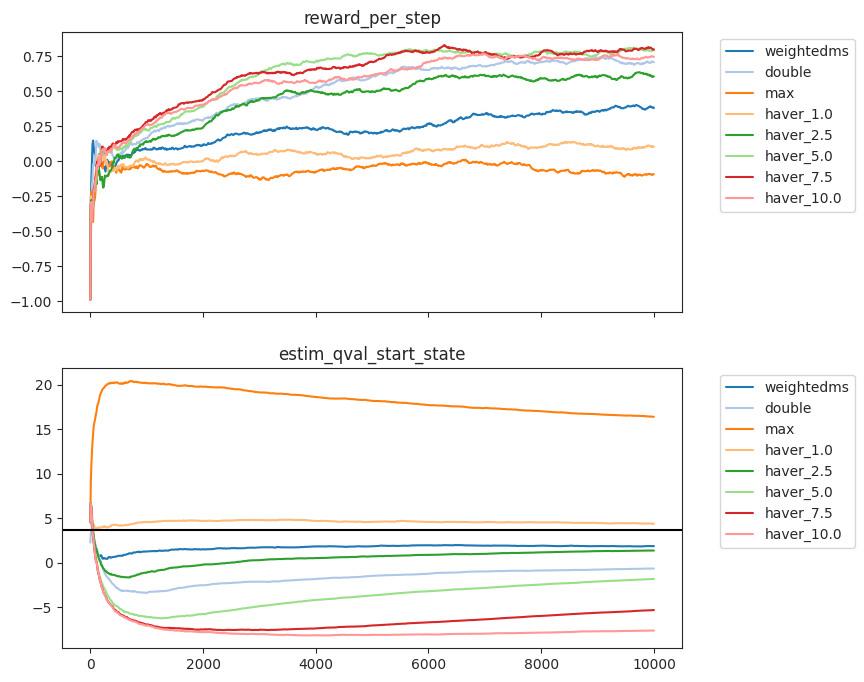

In [3]:

fig, axes = fig, axes = plt.subplots(
        nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))
# axes = [axes]

x_ary = np.linspace(0, num_steps_train-1, num=1000, dtype=np.int32)
for est_name in est_name_ary:
    # axes[0].plot(x_ary, episode_rewards_mean_dict[est_name][x_ary], label=est_name)
    y_ary = running_avg(episode_rewards_mean_dict[est_name][x_ary], 200)
    axes[0].plot(
        x_ary, y_ary, label=est_name)
    axes[1].plot(x_ary, episode_start_muhats_mean_dict[est_name][x_ary], label=est_name)
    # axes[2].plot(x_ary, episode_start_sigmahats_mean_dict[est_name][x_ary], label=est_name)

axes[0].axhline(y=0.92, color="black")
axes[1].axhline(y=3.70, color="black")
axes[0].set_title("reward_per_step")
axes[1].set_title("estim_qval_start_state")
# axes[2].set_title("episode_length")
axes[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axes[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# axes[2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [5]:
# fig, axes = fig, axes = plt.subplots(
#         nrows=1, ncols=1, sharex=True, sharey=False, figsize=(8,8))
# axes = [axes]

# x_ary = np.linspace(2000, num_steps_train-1, num=1000, dtype=np.int32)
# est_name_ary2 = haver_name_ary + ["weightedms"]
# for est_name in est_name_ary2:
#     axes[0].plot(x_ary, episode_start_sigmahats_mean_dict[est_name][x_ary], label=est_name)

    
# axes[0].set_title("Q_sigmahat")
# # axes[0].set_ylim([0, 1])
# axes[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.show()